By: **Andrey Núñez** & **Eric Walzthöny**

## PATHS

In [ ]:
PATH_INPUT = '/content/drive/MyDrive/Notebooks/IHLT/Labs/test-gold/STS.input.SMTeuroparl.txt'
PATH_GS = '/content/drive/MyDrive/Notebooks/IHLT/Labs/test-gold/STS.gs.SMTeuroparl.txt'
OUT_PATH = '/content/drive/MyDrive/Notebooks/IHLT/Labs/lab6_data/'

## Imports

In [ ]:
#imports
import nltk
from nltk.corpus import wordnet_ic
from nltk.corpus import wordnet as wn
from nltk.metrics import jaccard_distance
from nltk.wsd import lesk
from scipy.stats import pearsonr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# suppress pandas copy error message
pd.options.mode.chained_assignment = None

In [30]:
#corpus and IC
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('wordnet_ic')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive',)


Mounted at /content/drive


## Functions

In [ ]:
# Mapping of Stanford POS-tag to WordNet type
#thanks to pywsd ! 
#https://github.com/alvations
from nltk.corpus import wordnet as wn
def penn2morphy(penntag, returnNone=False):
    morphy_tag = {'NN':wn.NOUN, 'JJ':wn.ADJ,
                  'VB':wn.VERB, 'RB':wn.ADV}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return None if returnNone else ''

## Part I: Reading Pairs of Sentences

Reading all the pairs of sentences

In [ ]:
# Reading
dt = pd.read_csv(PATH_INPUT,sep='\t',header=None)
dt = dt.rename(columns={0: 'Set_A', 1: 'Set_B'})
#df['gs'] = pd.read_csv(PATH_GS,sep='\t',header=None)

## Part II: Lesk's Algorithm and Senses

In [ ]:
# tokenizing the sentence 
dt['Set_A'] = dt['Set_A'].apply(lambda x: nltk.sent_tokenize(x))
dt['Set_A'] = dt['Set_A'].apply(lambda x: nltk.word_tokenize(x[0]))
# Set B
dt['Set_B'] = dt['Set_B'].apply(lambda x: nltk.sent_tokenize(x))
dt['Set_B'] = dt['Set_B'].apply(lambda x: nltk.word_tokenize(x[0]))
# adding the pos tag 
dt['Set_A_POS'] = dt['Set_A'].apply(lambda x: nltk.pos_tag(x))
dt['Set_B_POS'] = dt['Set_B'].apply(lambda x: nltk.pos_tag(x))

In [ ]:
rest_lesk_Set_A = []
rest_lesk_Set_B = []
#SetA
for idx1, lists in enumerate(dt['Set_A']):
  context_sentence = lists
  l = []
  for idx2,words in enumerate(context_sentence): 
    amibgious_word = words 
    corr_pos_tag = penn2morphy(dt['Set_A_POS'][idx1][idx2][1])
    res_lesk = lesk(context_sentence,amibgious_word,corr_pos_tag)
    if type(res_lesk) == type(None):
      continue
    res_lesk = res_lesk.name()
    l.append(res_lesk)
  rest_lesk_Set_A.append(l)


# same for SetB
for idx1, lists in enumerate(dt['Set_B']):
  context_sentence = lists
  l = []
  for idx2,words in enumerate(context_sentence): 
    amibgious_word = words 
    corr_pos_tag = penn2morphy(dt['Set_B_POS'][idx1][idx2][1])
    res_lesk = lesk(context_sentence,amibgious_word,corr_pos_tag)
    if type(res_lesk) == type(None):
      continue
    res_lesk = res_lesk.name()
    l.append(res_lesk)
  rest_lesk_Set_B.append(l)

df1 = pd.DataFrame({'Sense_A':rest_lesk_Set_A})
df2 = pd.DataFrame({'Sense_B':rest_lesk_Set_B})
df3 = pd.concat([df1,df2],axis=1)
assert dt.shape[0] == df3.shape[0]


## Part III: Jaccard Distance & Pearson

In [ ]:
df3['Set_Sense_A'] = df3['Sense_A'].apply(lambda x: set(x))
df3['Set_Sense_B'] = df3['Sense_B'].apply(lambda x: set(x))
df3['jacc_distance'] = ''
for index in df3.index:
  df3['jacc_distance'][index] = 1- jaccard_distance(df3['Set_Sense_A'][index], df3['Set_Sense_B'][index])

df3['jacc_distance'] = pd.to_numeric(df3['jacc_distance'])

In [ ]:
finalized_df = pd.concat([dt,df3],axis=1)
finalized_df['gs'] = pd.read_csv(PATH_GS,sep='\t',header=None)


In [ ]:
pearsonr(finalized_df['gs'], finalized_df['jacc_distance'])[0]

0.43569949673295627

## Part IV - V: Comparing to Session 2 & 3 & Resulting Jaccard Distance & Pearson Correlation

In [ ]:
# reading saved csv files
dfjs2 = pd.read_csv(OUT_PATH+'Jaccard_Session2.csv')
dfjs3 = pd.read_csv(OUT_PATH+'Jaccard_Session3.csv')

#reading original files
df_eval = pd.read_csv(PATH_INPUT,sep='\t',header=None)
df_eval = df_eval.rename(columns={0: 'SentA', 1: 'SentB'})

In [ ]:
# adding Jaccard distances and gs
df_eval['jd_session2'] = dfjs2['jaccard'].values
df_eval['jd_session3'] = dfjs3['jacc_distance'].values
df_eval['jd_session6'] = finalized_df['jacc_distance'].values
df_eval['gs'] = pd.read_csv(PATH_GS,sep='\t',header=None)

In [ ]:
'''
Words  --> Session 2 --> Document 
Lemmas --> Session 3 --> Morphology
Sense  --> Session 6 --> Lesks

'''

d = {'Words':pearsonr(df_eval['gs'], df_eval['jd_session2'])[0],
     'Lemmas':pearsonr(df_eval['gs'], df_eval['jd_session3'])[0],
     'Senses':pearsonr(df_eval['gs'], df_eval['jd_session6'])[0]}
df = pd.DataFrame.from_dict(d,orient='index',columns=['Pearson Correlation'])

In [ ]:
# final result
df.head()

,Pearson Correlation
Words,0.450498
Lemmas,0.456911
Senses,0.435699


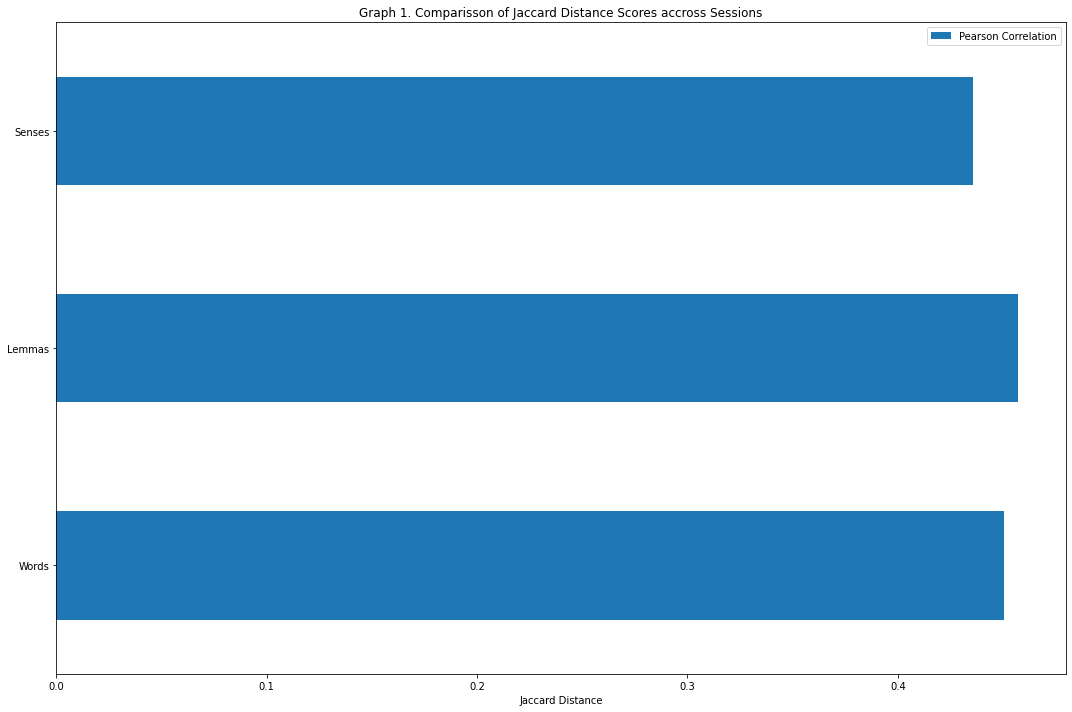

In [ ]:
# lets graph it to see 
g = df.plot(kind='barh',
        title='Graph 1. Comparisson of Jaccard Distance Scores accross Sessions',
        figsize=(15,10),
        )
g.set_xlabel('Jaccard Distance')
plt.tight_layout() 

In [ ]:
include_cols = ['jd_session2','jd_session3','jd_session6']
df_jds = df_eval[include_cols].copy()

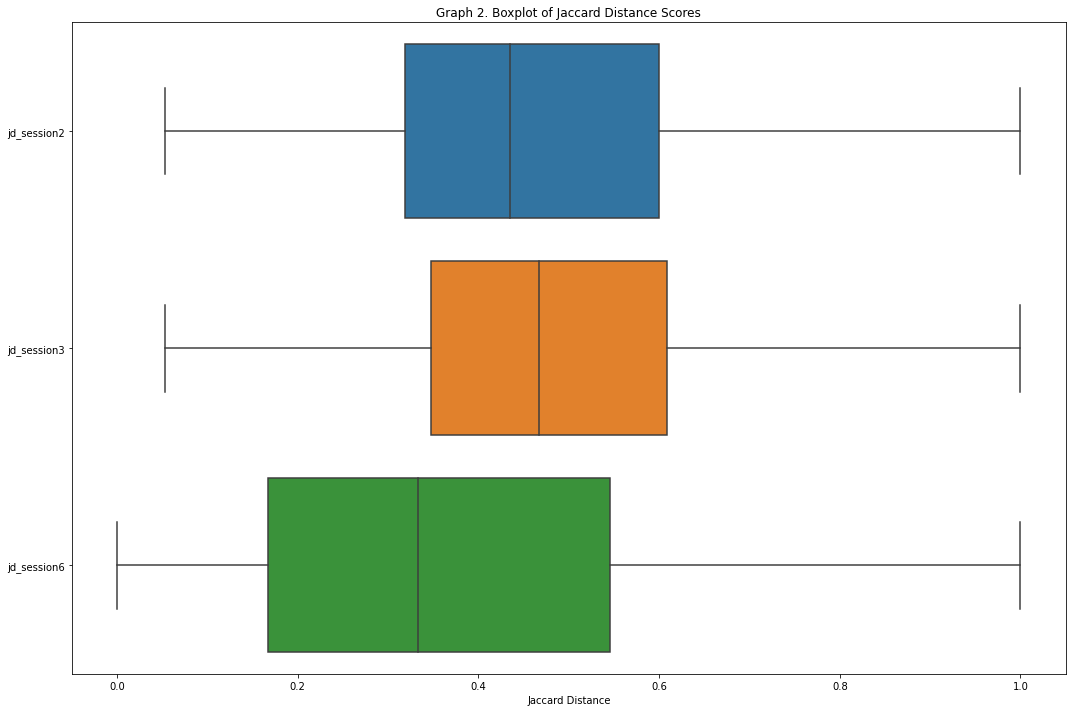

In [ ]:
# how does the data look like actually?
FIG_SIZE = (15,10)
plt.figure(figsize=FIG_SIZE)

ax = sns.boxplot(data=df_jds, orient="h")
ax.set_title('Graph 2. Boxplot of Jaccard Distance Scores')
ax.set_xlabel('Jaccard Distance')
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 10.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 8.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 12.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


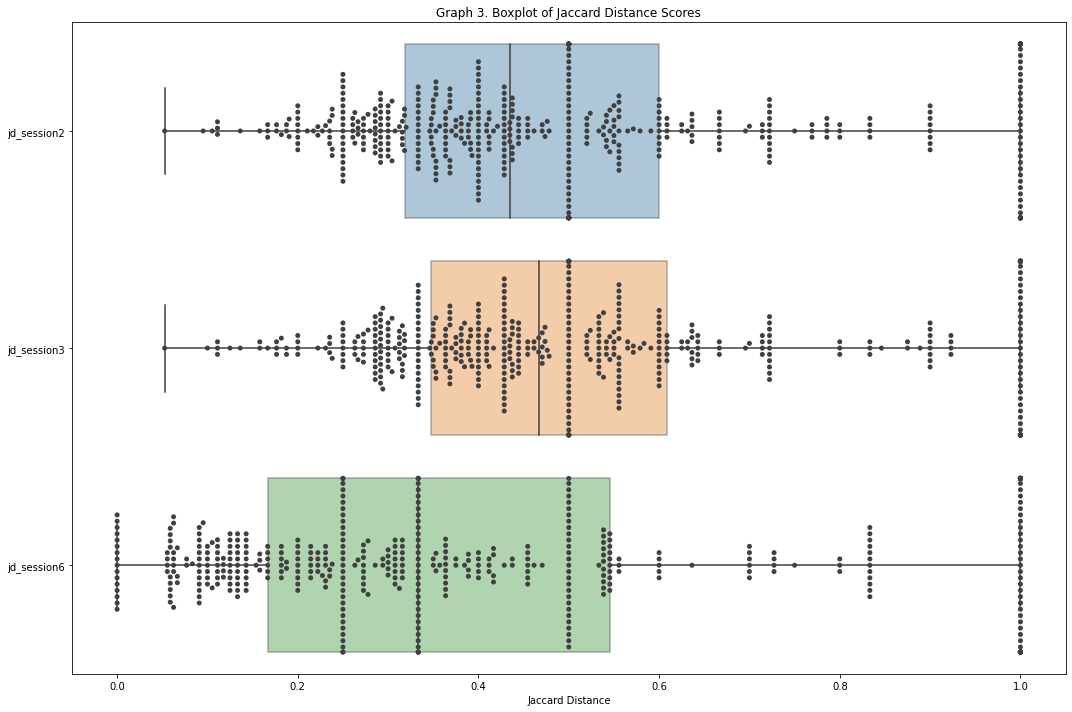

In [ ]:
# let's look at it with a swarmplot on top of it
FIG_SIZE = (15,10)
plt.figure(figsize=FIG_SIZE)
ax = sns.boxplot(data=df_jds, orient="h",boxprops=dict(alpha=0.4))
ax = sns.swarmplot(data=df_jds,orient="h",s=5,color="0.25")
ax.set_title('Graph 3. Boxplot of Jaccard Distance Scores')
ax.set_xlabel('Jaccard Distance')
plt.tight_layout()

In [ ]:
# the graph itself doesn't tell us much, lets look at the difference between sessions
df_eval['Delta1'] = df_eval['jd_session3'] - df_eval['jd_session2']
df_eval['Delta2'] = df_eval['jd_session6'] - df_eval['jd_session3']
df_eval['Delta3'] = df_eval['jd_session6'] - df_eval['jd_session2']

count    459.000000
mean       0.019717
std        0.057687
min       -0.363636
25%        0.000000
50%        0.000000
75%        0.033333
max        0.285714
Name: Delta1, dtype: float64


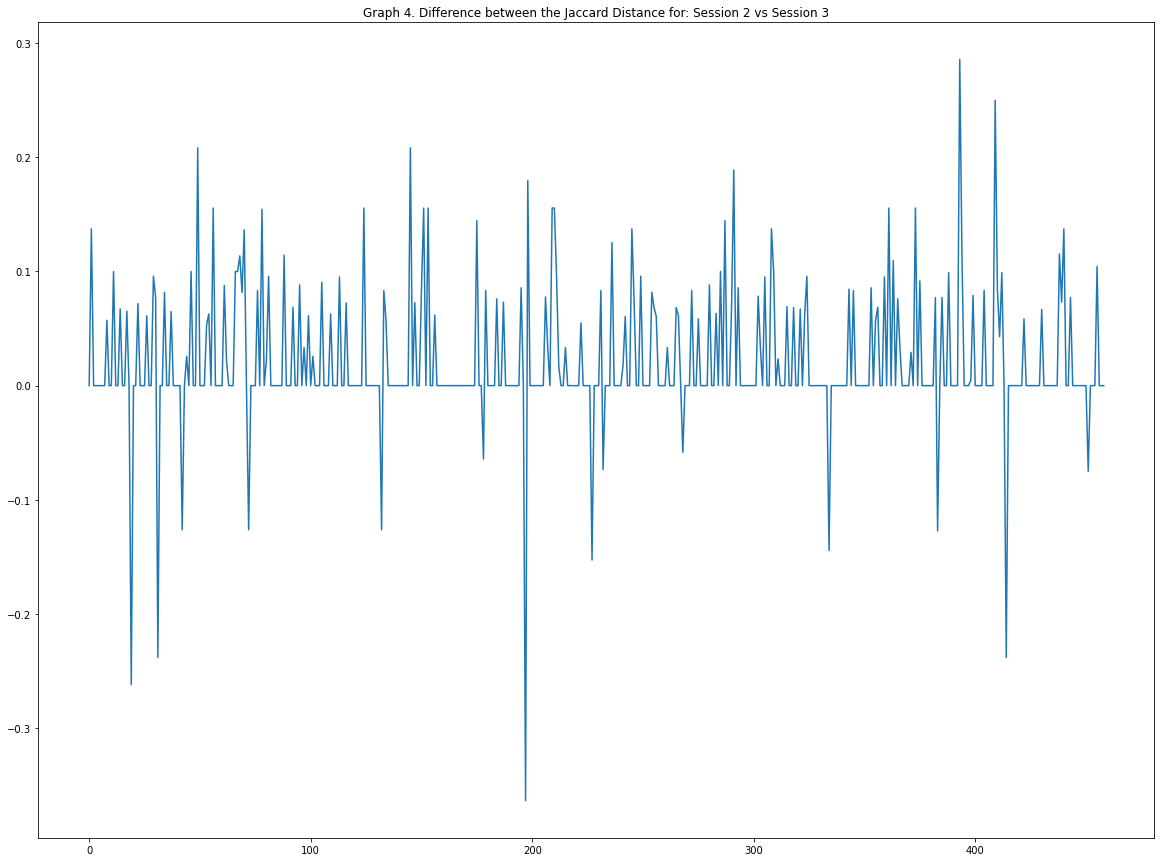

count    459.000000
mean      -0.103911
std        0.179597
min       -0.666667
25%       -0.220795
50%       -0.136364
75%        0.000000
max        0.777778
Name: Delta2, dtype: float64


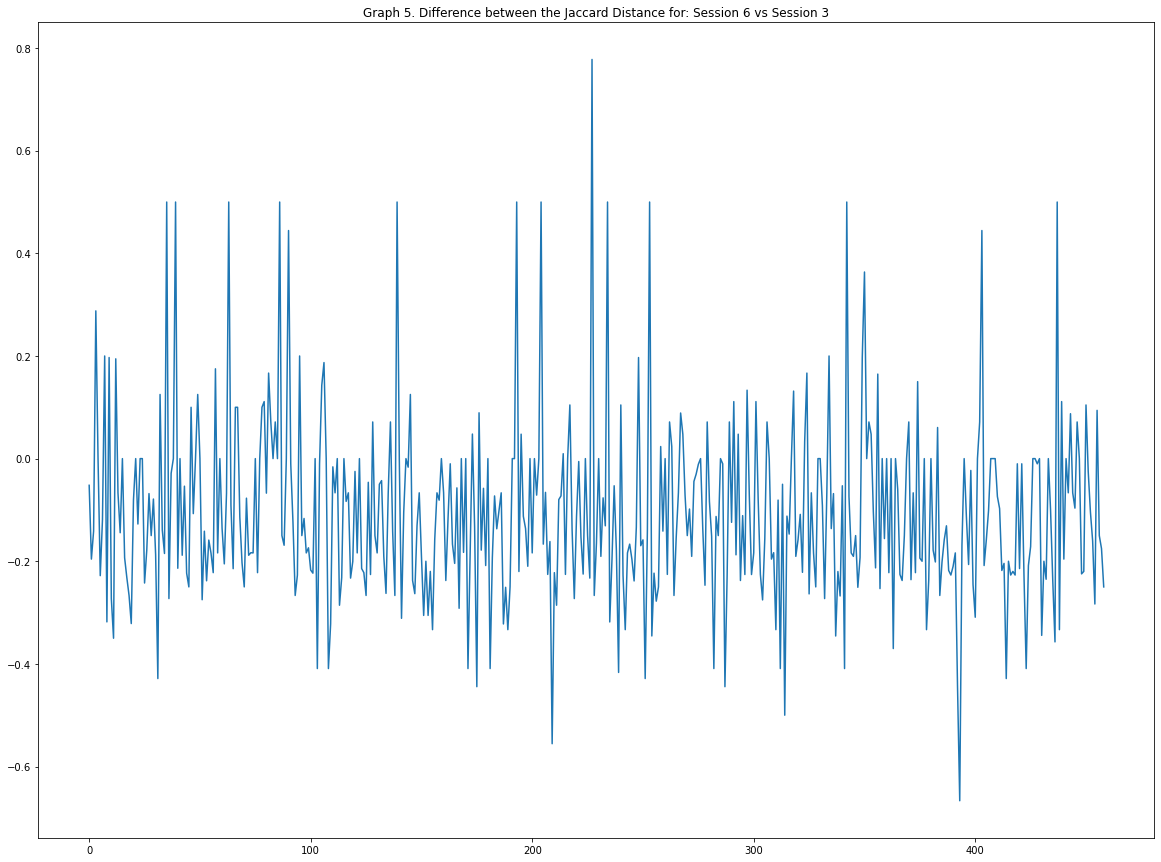

count    459.000000
mean      -0.084194
std        0.181864
min       -0.666667
25%       -0.195466
50%       -0.100000
75%        0.000000
max        0.625000
Name: Delta3, dtype: float64


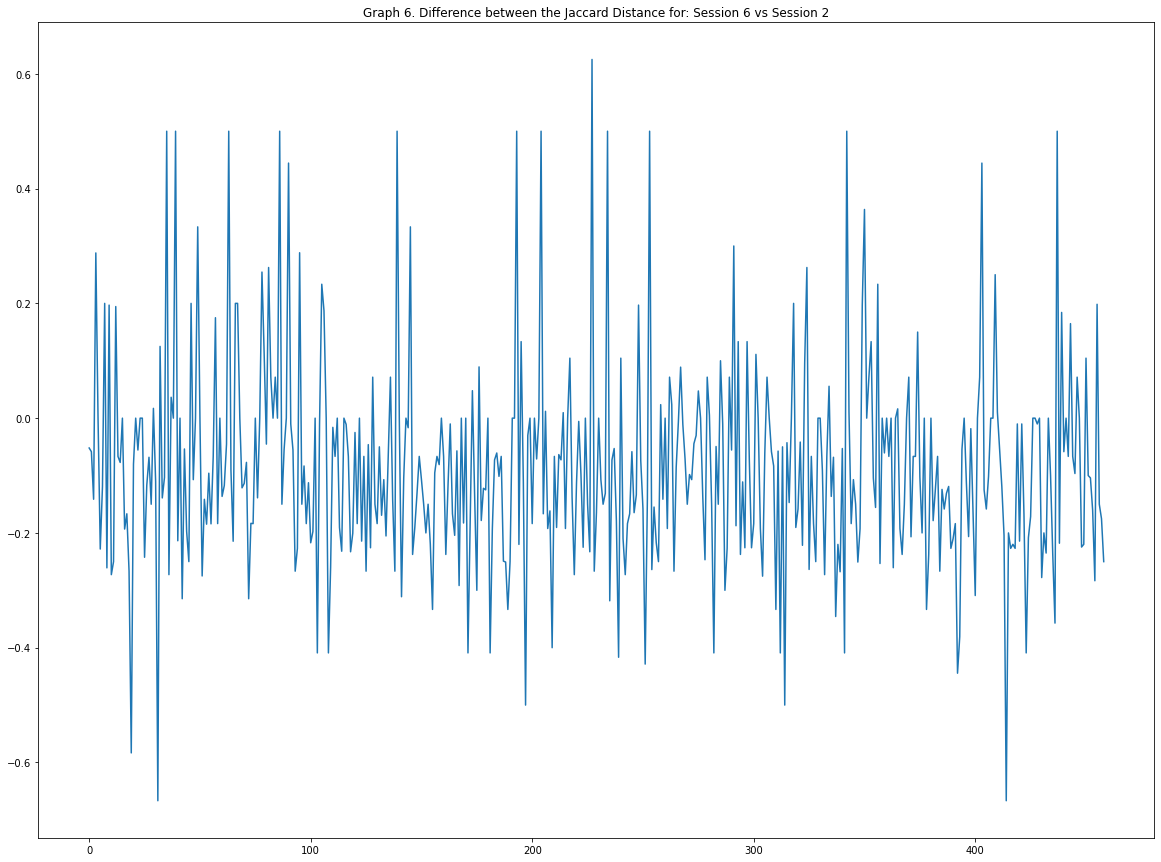

In [ ]:
# looking at the Delta between sessions --> How much does it vary?

for idx, i in enumerate([('Delta1','Session 2 vs Session 3'),('Delta2','Session 6 vs Session 3'),('Delta3','Session 6 vs Session 2')]):
  df_eval[i[0]].plot(figsize=(20,15), title=f"Error : {i[1]}")
  plt.title(f"Graph {idx+4}. Difference between the Jaccard Distance for: {i[1]}")
  print(df_eval[i[0]].describe())
  plt.show()

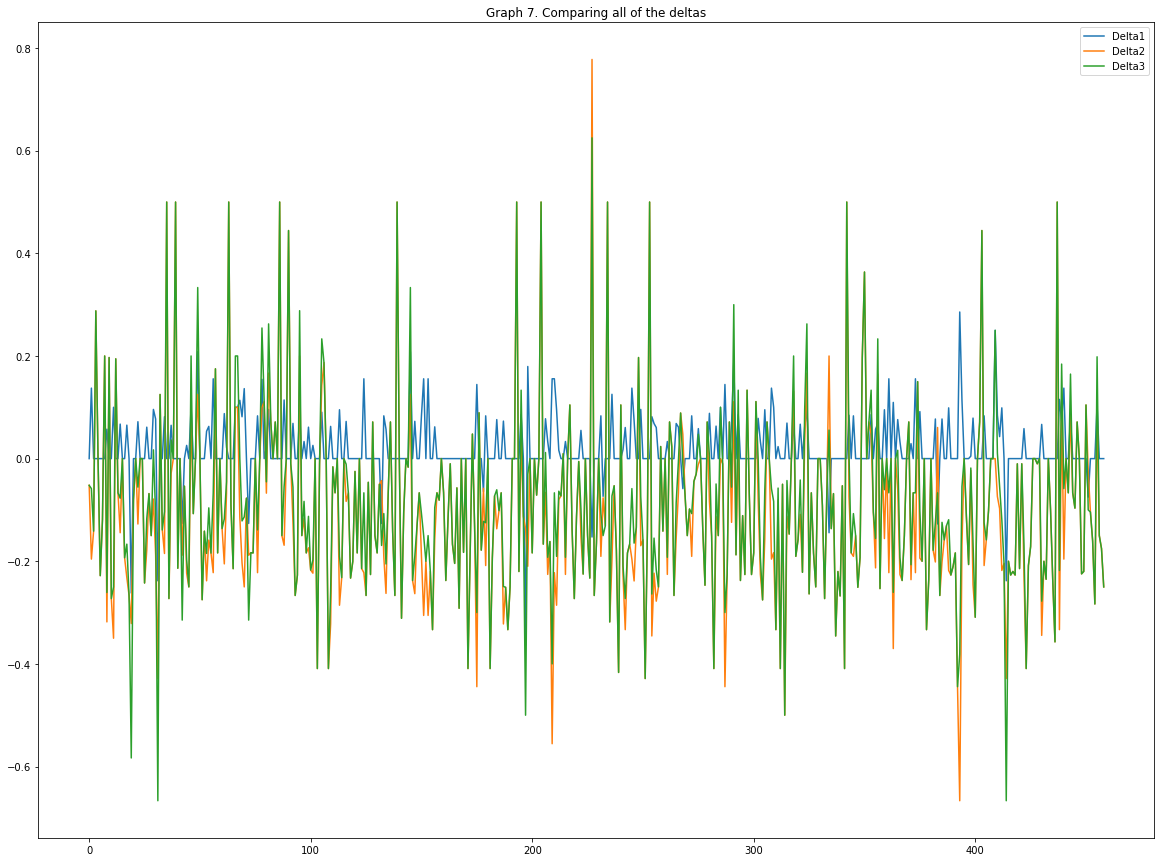

In [ ]:
#looking at al the deltas together
df_eval[['Delta1','Delta2','Delta3']].plot(figsize=(20,15), title='Graph 7. Comparing all of the deltas')
plt.show()

In [ ]:
# looking at the mean for all of the Sessions
df_jds.mean()

jd_session2    0.500240
jd_session3    0.519957
jd_session6    0.416046
dtype: float64

# Report

## Description
This task is going to be divided into smaller parts. First we will read the files, apply Lesk's algorithm, then apply the Jaccard Distance & Pearson Coefficient. Lastly, comparing them to Session 2 and 3. 

We will be using Lesk's algorithm, since we are the nltk module their definition of it is the following "Synset with the highest number of overlapping words between the context sentence and different definitions from each Synset." (NLTK). Here the context sentence is a single sentence from one of the pairs of sentences from "STS.input.SMTeuroparl.txt". We use the same procedure as previous labs to treat the sentences by tokenizing and getting their POS tag. Now for each word we will get the synsets given the context. From that we will compare the similarities between these two. 

Then the Jaccard Distance and Pearson Coefficient will be done in the same fashion as the comparisson sessions. 


## Evaluation
We can see that Lesk's algorithm provides another method to getting the synsets as well as comparing two different sentences. In this case it requires a context sentence to find the corresponding synset. It is interesting to note that in this notebook using Lesk's algorithm lead to a lower Pearson value. Upon further inspection we can see in Graph 2, that the interquartile range of the values has been shifted to the left. This can also be corroborated looking at the mean of the jaccard distsance for each session. 

Additionally, we also saw that Session 2 and 3 were very similar in their boxplots, yet the range of Session 6 is much larger comapred to the others. *Note: here the range we refer to as the Interquartile range. 
We can see that using the combination of all three of these methods depends on the situation one wants to analyze the text. Lesk's algorithm provides a different approach implementing the POS tag and the context sentence (which already has been tokenized).  

## Summary
We provided a comparisson of the methods done during these three laboratory sessions and noting the difference between this session (Laboratory 6). We saw that the Jaccard Distance for the sessions differed. Mostly it was seen at session 6 which had the lowest jaccard distance of them all. 




## Citations

https://www.nltk.org/howto/wsd.html

